# Bootstrapping of Average Annualised Returns

__"Bootstrapping" is a form of random resampling method that performs same size re-sampling with replacement__. This can help to illustrate the uncertainty in terms of samples estimation (such as mean values). An illustration is shown below on how bootstrap sampling is performed.

<!-- ![](./img/bootstrap_demo.png) -->
<div align="center">
    <img src=./img/bootstrap_demo.png>
</div>

With multiple bootstrap samples, we can calculate the mean of each bootstrap sample and plot the histogram to visualise the uncertainty/variance in the mean estimates.

### Bootstrapping of Seahorse's Composite Strategy Annualised Returns 

For each strategy, we have a yearly breakdown of the annualised return metric (21 values based on 21 years). As an example, the following shows the 21 yearly values of the annualised return metric for the Benchmark Strategy (Filter 1 + Filter2).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os import listdir
from os.path import isfile, join

In [2]:
pd.read_csv("./buy/f2_buy.csv", index_col = 0)

,filter(1+2)
year,
2000,-0.035994
2001,0.398430
2002,-0.301696
2003,0.590143
2004,0.286830
2005,0.213718
2006,0.183338
2007,-0.074631
2008,-0.033629


We can perform bootstrapping on the different strategies to understand the distribution of the average value across all years.

This notebook will compare the bootstrap samples means histogram for the __benchmark strategy (Filter 1+2)__ versus the top combinations from each composite strategy type:
- Moving Average (MA)
- Exponentially Weighted Moving Average (EWMA)
- Relative Strength Index (RSI)
- MA-MACD
- EWMA-MACD

# Hypothesis Testing of Composite Strategies versus Benchmark strategy

Using the bootstrap samples, we can perform hypothesis testing of the bootstrap samples means. The hypothesis test is framed accordingly:
- __Null Hypothesis ($H_0$)__: The average annualised return metric of the benchmark strategy is the same as the average annualised return metric of the alternate composite strategy. [$\mu_{benchmark} = \mu_{alternate}$]
- __Alternate Hypothesis ($H_1$)__: The average annualised return metric of the alternate composite strategy is greater than the average annualised return metric of the benchmark strategy. [$\mu_{alternate} > \mu_{benchmark}$]

For the hypothesis test, we will perform bootstrap sampling according to years, such that we can calculate the difference in annualised returns between the alternate and benchmark strategies for each resampled year. Thereafter, we find the mean of the bootstrap samples and calculate the p-value for the hypothesis test.

In consideration that we will be performing multiple hypothesis comparison, we will adopt the __Benjamini-Hochberg (BH)__ correction to control for false discovery rates.

In our following analysis, we will be importing custom functions located in the "boostrapping_custom_functions.py" file:
- __bootstrap_sampling__: Performs bootstrap resampling on an input array
- __p_adjust_bh__: Performs Benjamini-Hochberg (BH) correction for multiple hypothesis testing 
- __paired_histrograms_buy__: Visualisation function for Buy signals
- __paired_histograms_sell__: Visualisation function for Sell signals

In [3]:
from bootstrapping_custom_functions import bootstrap_sampling, p_adjust_bh, paired_histograms_buy, paired_histograms_sell

## Buy/Long Signals

Let's start with the bootstrapping and hypothesis testing of strategy comparisons for Buy/Long trade signals.

In [4]:
directory_path = "./buy/"

files_list = [f for f in listdir(directory_path) if isfile(join(directory_path, f))]
files_list.sort(key=len)
for i in range(len(files_list)):
    data_path = directory_path + files_list[i]

    if i == 0:
        buy_df = pd.read_csv(data_path, index_col = 0)

    else:
        intermediate_df = pd.read_csv(data_path, index_col = 0)

        buy_df = pd.concat([buy_df, intermediate_df], axis = 1)

For the Buy Only trade signals, we can take a look at the __best parameter combination for each strategy type__ based on the column names of the dataframe, including the benchmark strategy.

In [5]:
[str(i).upper() for i in buy_df.columns]

['FILTER(1+2)',
 'MA(28/13)',
 'RSI(83/13)',
 'EWMA(26/13)',
 'MA(10/13)_MACD(5,35,5)',
 'EWMA(12/13)_MACD(5,35,5)']

After reading the data, we can take a look at the yearly breakdown of the annualised return metric for each strategy combination type.

In [6]:
buy_df

,filter(1+2),ma(28/13),rsi(83/13),ewma(26/13),"ma(10/13)_macd(5,35,5)","ewma(12/13)_macd(5,35,5)"
2000,-0.035994,0.323607,3.005298,-0.820172,0.592585,-0.310291
2001,0.398430,0.479691,0.716626,0.639977,0.543886,0.610342
2002,-0.301696,-0.108452,0.148715,-0.058318,0.481178,0.414036
2003,0.590143,0.992856,0.740439,1.046737,0.599916,0.815065
2004,0.286830,0.274514,0.630377,0.062848,0.518141,0.045982
2005,0.213718,0.277258,0.552292,0.147553,0.106581,-0.047764
2006,0.183338,-0.220479,1.048695,-0.237680,-0.013998,0.248761
2007,-0.074631,0.371396,0.294346,0.097144,0.070767,0.009711
2008,-0.033629,-0.318562,3.905281,0.560449,0.217555,0.535980
2009,0.577619,1.109288,1.512005,0.730389,0.624446,0.793251


Now that we have the data, we can perform the bootstrapping procedure on the different strategies. Note that by specifying the `random_state`, this makes the sampling reproducible.

At the same time, we also specify the same `random_state` such that the bootstrap sampling for all strategies have the same resampling in terms of years. This allows us to easily use the bootstrap sample arrays for the hypothesis test framework with a simple arithmetic subtraction operation (alternate strategy minus benchmark strategy).

In [7]:
# Bootstrap Sampling with reproducible random state = 1
random_state = 1

# Using the same random_state ensures that the BS sampling for the different strategies are the same in terms of years
benchmark_buy = bootstrap_sampling(np.array(buy_df["filter(1+2)"]), random_state = random_state)
rsi_buy = bootstrap_sampling(np.array(buy_df["rsi(83/13)"]), random_state = random_state)
ma_buy = bootstrap_sampling(np.array(buy_df["ma(28/13)"]), random_state = random_state)
ewma_buy = bootstrap_sampling(np.array(buy_df["ewma(26/13)"]), random_state = random_state)
ma_macd_buy = bootstrap_sampling(np.array(buy_df["ma(10/13)_macd(5,35,5)"]), random_state = random_state)
ewma_macd_buy = bootstrap_sampling(np.array(buy_df["ewma(12/13)_macd(5,35,5)"]), random_state = random_state)

With the relevant bootstrap sample arrays for Buy Signals, we can use them a custom visualisation function `paired_histograms_buy` that consist of:
- __Left Chart__: Distributions of bootstrap sampling means for both the benchmark and alternate strategy name
- __Right Chart__: Distribution of hypothesis testing comparison between benchmark and alternate strategy
- __p-value calculation__: This is the p-value for the hypothesis test using the bootstrap samples

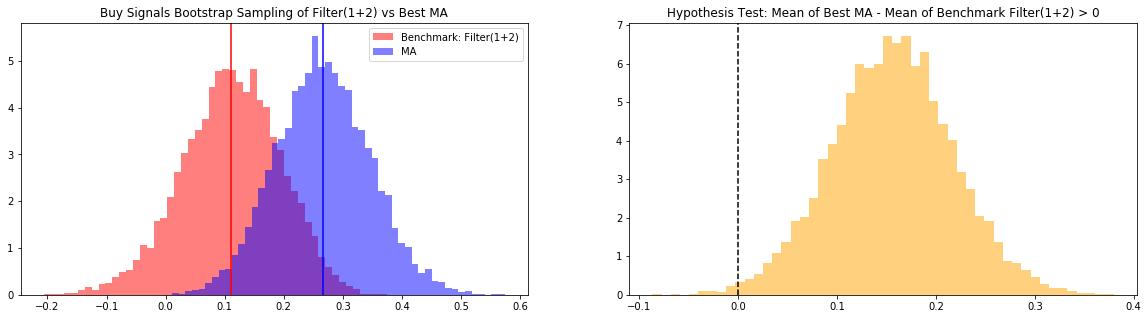

The p-value for hypothesis test (Mean of Best MA - Mean of Benchmark Filter(1+2) > 0) is 0.006


In [8]:
paired_histograms_buy(ma_buy, "MA", benchmark_buy)

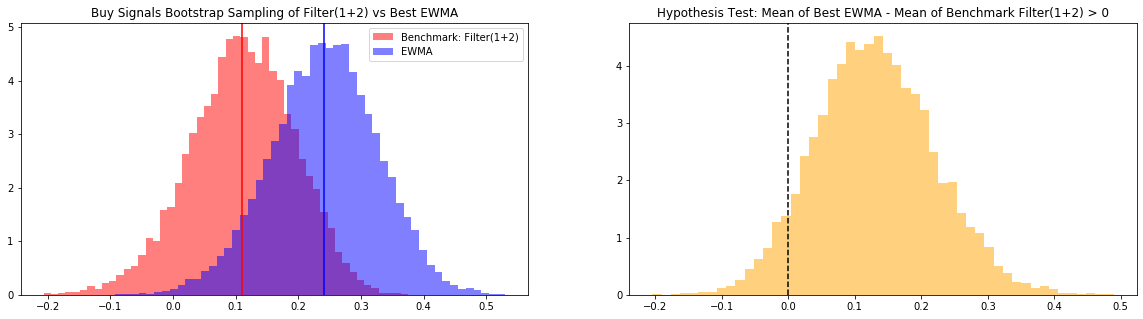

The p-value for hypothesis test (Mean of Best EWMA - Mean of Benchmark Filter(1+2) > 0) is 0.068


In [9]:
paired_histograms_buy(ewma_buy, "EWMA", benchmark_buy)

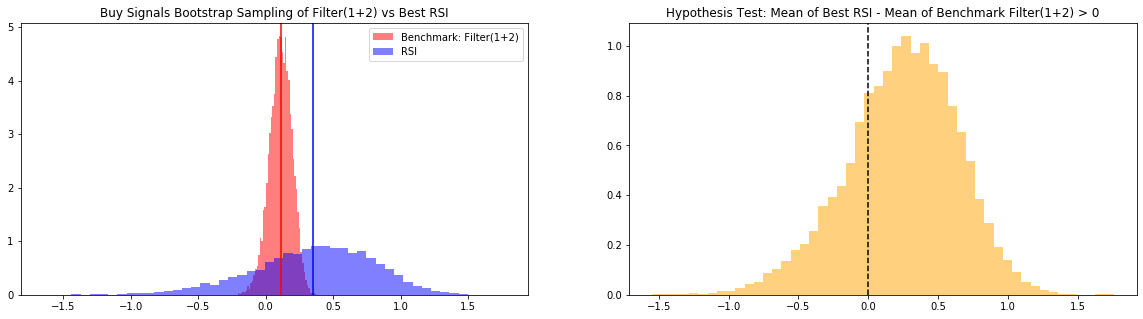

The p-value for hypothesis test (Mean of Best RSI - Mean of Benchmark Filter(1+2) > 0) is 0.256


In [10]:
paired_histograms_buy(rsi_buy, "RSI", benchmark_buy)

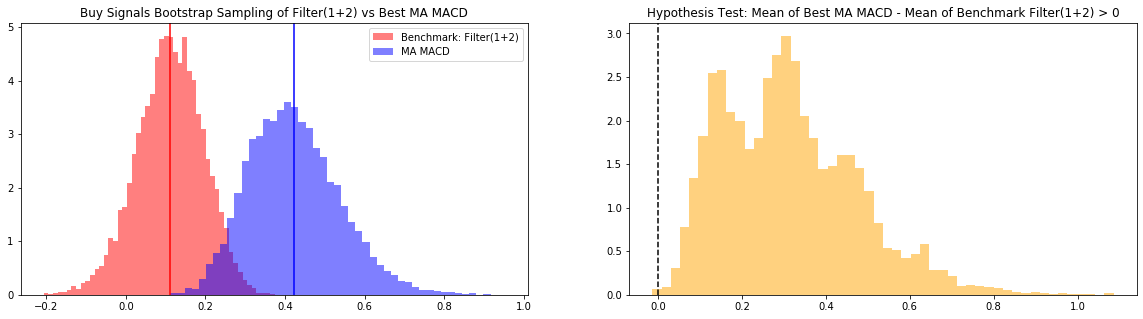

The p-value for hypothesis test (Mean of Best MA MACD - Mean of Benchmark Filter(1+2) > 0) is 0.001


In [11]:
paired_histograms_buy(ma_macd_buy, "MA MACD", benchmark_buy)

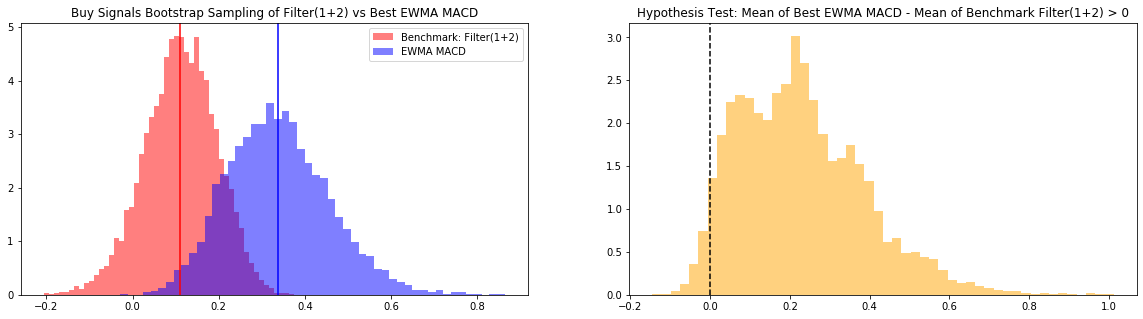

The p-value for hypothesis test (Mean of Best EWMA MACD - Mean of Benchmark Filter(1+2) > 0) is 0.036


In [12]:
paired_histograms_buy(ewma_macd_buy, "EWMA MACD", benchmark_buy)

Having seen the visualisations of the bootstrapping for each strategy and individual hypothesis tests,  we can now perform the multiple hypothesis test with BH correction.

In [13]:
# Compile in list
strategies_bootstrap_arrays_list = [ma_buy, ewma_buy, rsi_buy, ma_macd_buy, ewma_macd_buy]

p_values = np.empty(len(strategies_bootstrap_arrays_list))

# Recalculating all the p values 
for i in range(len(strategies_bootstrap_arrays_list)):
    p_values[i] = 1 - sum((strategies_bootstrap_arrays_list[i].mean(axis = 0) - benchmark_buy.mean(axis = 0)) >0)/len(strategies_bootstrap_arrays_list[i].mean(axis = 0))

# Performing Benjamini-Hochberg correction for multiple hypothesis testing
bh_adjusted_p_values = p_adjust_bh(p_values)

# Compilation results
buy_pval = pd.DataFrame([p_values, bh_adjusted_p_values]).T
buy_pval.index = ["MA", "EWMA", "RSI", "MA-MACD", "EWMA-MACD"]
buy_pval.columns = ["p-values", "BH-adjusted p-values"]

buy_pval.sort_values(by = "p-values")

,p-values,BH-adjusted p-values
MA-MACD,0.0006,0.003000
MA,0.0057,0.014250
EWMA-MACD,0.0364,0.060667
EWMA,0.0680,0.085000
RSI,0.2556,0.255600


Based on the hypothesis testing with BH correction, at 5% significance, we conclude that both MA-MACD and MA are statistically significant.

## Sell/Short Signals

Let's continue with the bootstrapping and hypothesis testing of strategy comparisons for Sell/Short trade signals.

In [14]:
directory_path = "./sell/"

files_list = [f for f in listdir(directory_path) if isfile(join(directory_path, f))]
files_list.sort(key=len)
for i in range(len(files_list)):
    data_path = directory_path + files_list[i]

    if i == 0:
        sell_df = pd.read_csv(data_path, index_col = 0)

    else:
        intermediate_df = pd.read_csv(data_path, index_col = 0)

        sell_df = pd.concat([sell_df, intermediate_df], axis = 1)

For the Sell Only trade signals, we can take a look at the __best parameter combination for each strategy type__ based on the column names of the dataframe, including the benchmark strategy.

In [15]:
[str(i).upper() for i in sell_df.columns]

['FILTER(1+2)',
 'MA(13/13)',
 'RSI(84/13)',
 'EWMA(34/13)',
 'MA(6/13)_MACD(8,17,9)',
 'EWMA(15/13)_MACD(8,17,9)']

After reading the data, we can take a look at the yearly breakdown of the annualised return metric for each strategy combination type.

In [16]:
sell_df

,filter(1+2),ma(13/13),rsi(84/13),ewma(34/13),"ma(6/13)_macd(8,17,9)","ewma(15/13)_macd(8,17,9)"
2000,0.291262,0.265082,2.280243,0.097781,1.107262,0.285025
2001,-0.222402,-0.308229,5.494154,-0.271570,-0.234830,0.008732
2002,-0.043236,-0.009942,2.856320,0.090600,0.089886,0.074072
2003,-0.411814,-0.343647,-0.156393,-0.504800,-0.340053,-0.523031
2004,-0.318771,-0.512695,-0.517816,-0.506067,-0.996271,-0.764961
2005,-0.142430,-0.447507,0.751345,-0.078621,-0.030340,-0.091509
2006,0.000874,-0.035048,0.195919,-0.026592,-0.350512,-0.489385
2007,-0.086245,0.056559,0.880302,-0.079393,-0.171058,-0.179090
2008,0.808165,0.918654,2.091160,0.918370,0.819421,0.958710
2009,-0.451770,-0.151875,0.195416,-0.322300,-0.107070,-0.033088


Similarly, now that we have the data, we can perform the bootstrapping procedure on the different strategies.

In [17]:
# Bootstrap Sampling with reproducible random state = 1
random_state = 1

# Using the same random_state ensures that the BS sampling for the different strategies are the same in terms of years
benchmark_sell = bootstrap_sampling(np.array(sell_df["filter(1+2)"]), random_state = random_state)
rsi_sell = bootstrap_sampling(np.array(sell_df["rsi(84/13)"]), random_state = random_state)
ma_sell = bootstrap_sampling(np.array(sell_df["ma(13/13)"]), random_state = random_state)
ewma_sell = bootstrap_sampling(np.array(sell_df["ewma(34/13)"]), random_state = random_state)
ma_macd_sell = bootstrap_sampling(np.array(sell_df["ma(6/13)_macd(8,17,9)"]), random_state = random_state)
ewma_macd_sell = bootstrap_sampling(np.array(sell_df["ewma(15/13)_macd(8,17,9)"]), random_state = random_state)

With the bootstrap samples obtained, we can visualise the bootstrap sampling means and the hypothesis test distribution as well.

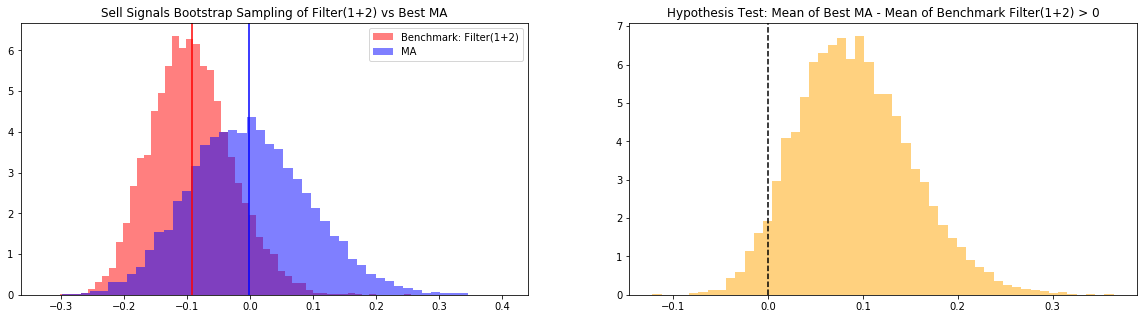

The p-value for hypothesis test (Mean of Best MA - Mean of Benchmark Filter(1+2) > 0) is 0.051


In [18]:
paired_histograms_sell(ma_sell, "MA", benchmark_sell)

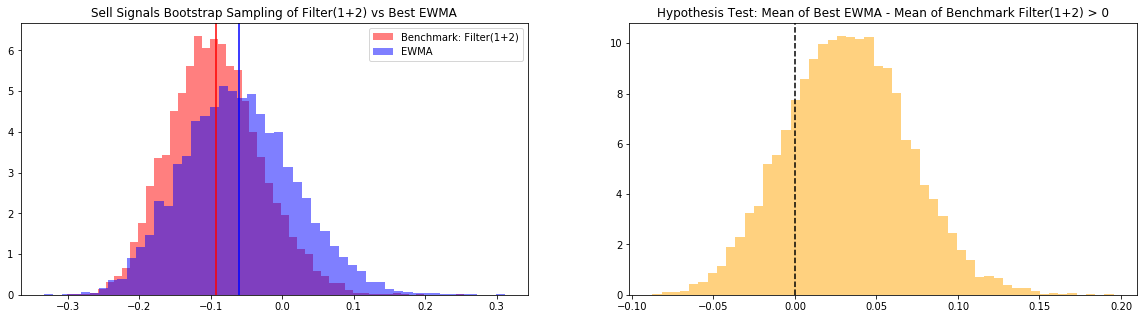

The p-value for hypothesis test (Mean of Best EWMA - Mean of Benchmark Filter(1+2) > 0) is 0.199


In [19]:
paired_histograms_sell(ewma_sell, "EWMA", benchmark_sell)

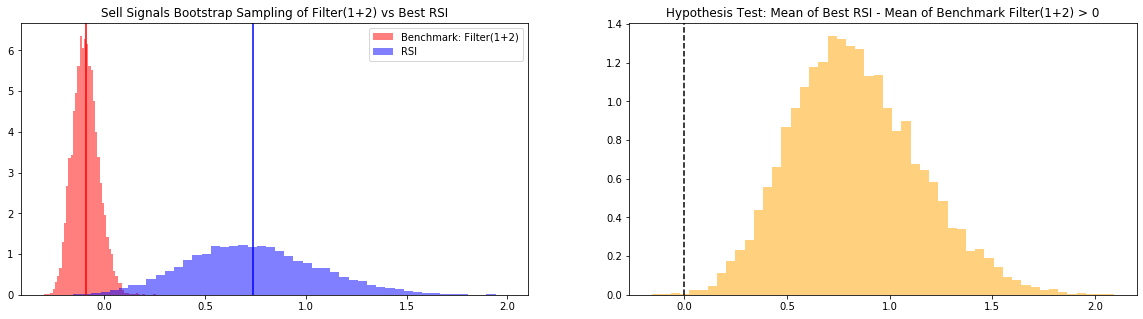

The p-value for hypothesis test (Mean of Best RSI - Mean of Benchmark Filter(1+2) > 0) is 0.001


In [20]:
paired_histograms_sell(rsi_sell, "RSI", benchmark_sell)

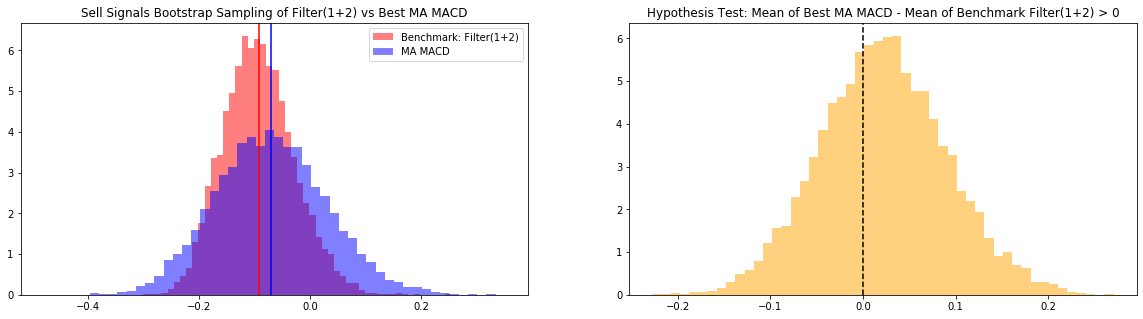

The p-value for hypothesis test (Mean of Best MA MACD - Mean of Benchmark Filter(1+2) > 0) is 0.377


In [21]:
paired_histograms_sell(ma_macd_sell, "MA MACD", benchmark_sell)

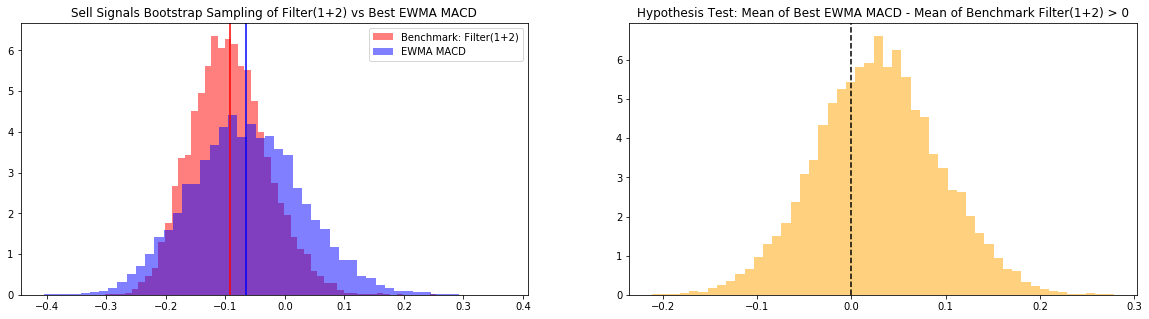

The p-value for hypothesis test (Mean of Best EWMA MACD - Mean of Benchmark Filter(1+2) > 0) is 0.337


In [22]:
paired_histograms_sell(ewma_macd_sell, "EWMA MACD", benchmark_sell)

Having seen the visualisations of the bootstrapping for each strategy and individual hypothesis tests,  we can now perform the multiple hypothesis test with BH correction.

In [23]:
# Compile in list
strategies_bootstrap_arrays_list = [ma_sell, ewma_sell, rsi_sell, ma_macd_sell, ewma_macd_sell]

p_values = np.empty(len(strategies_bootstrap_arrays_list))

# Recalculating all the p values 
for i in range(len(strategies_bootstrap_arrays_list)):
    p_values[i] = 1 - sum((strategies_bootstrap_arrays_list[i].mean(axis = 0) - benchmark_sell.mean(axis = 0)) >0)/len(strategies_bootstrap_arrays_list[i].mean(axis = 0))

# Performing Benjamini-Hochberg correction for multiple hypothesis testing
bh_adjusted_p_values = p_adjust_bh(p_values)

# Compilation results
sell_pval = pd.DataFrame([p_values, bh_adjusted_p_values]).T
sell_pval.index = ["MA", "EWMA", "RSI", "MA-MACD", "EWMA-MACD"]
sell_pval.columns = ["p-values", "BH-adjusted p-values"]

sell_pval.sort_values(by = "p-values")

,p-values,BH-adjusted p-values
RSI,0.0008,0.00400
MA,0.0507,0.12675
EWMA,0.1986,0.33100
EWMA-MACD,0.3373,0.37720
MA-MACD,0.3772,0.37720


Based on the hypothesis testing with BH correction, at 5% significance, we conclude that only RSI is statistically significant.